In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pandas_profiling import ProfileReport
import plotly.figure_factory as ff
import plotly.graph_objects as go
import datetime 
from dateutil.parser import parse
import nbformat
from functools import reduce

In [36]:
RAW_DATA_FOLDER = 'data/raw/'
OUTPUT_DATA_FOLDER = 'data/output/'
REPORT_FOLDER = 'reports/'

#sectors and countries that we are interested
sector_list = ['Energy Storage & Management', 'Industry 4.0', 'Mobility & Automotive', 'Supply Chain & Logistics', 'Other']
country_list = ['Germany', 'Turkey', 'United Kingdom', 'Other']

pipeline = pd.read_csv(os.path.join(RAW_DATA_FOLDER, 'pipeline.csv'))

CUMULATIVE = True
#set_indexes([energy, industry, sc_logistics, mobility], ["id", "id", "id", "id"])

In [37]:
#standardize the date input
pipeline.rename(columns={'Day Created': 'Date'}, inplace=True)
#pipeline['Date'] = pipeline['Date'].str.replace('.', '-')
#pipeline['Date'] = pipeline['Date'].str.replace('/', '-')
#pipeline['One Pager Date'] = pipeline['One Pager Date'].str.replace('.', '-')
#pipeline['One Pager Date'] = pipeline['One Pager Date'].str.replace('/', '-')
pipeline.loc[~pipeline['Country'].isin(country_list), 'Country'] = 'Other'
#get rid of irrelevant rows
pipeline.dropna(subset = ['Sector'], inplace=True)
pipeline.replace("-", np.nan, inplace=True)

In [38]:
pipeline[pipeline["Term Sheet Date"].notnull()]["Term Sheet Date"]

34       12/11/18
35     26.12.2018
62       11/02/19
131    16.05.2019
240    22.10.2019
266    17.10.2020
471      12/05/20
472    21.08.2020
536      10/05/20
614    23.10.2020
616    25.09.2020
Name: Term Sheet Date, dtype: object

In [39]:
#adjust time format
pipeline["Date"] = pd.to_datetime(pipeline["Date"]).dt.strftime('%Y-%m-%d')
pipeline["Date"] = pipeline["Date"].apply(lambda x : parse(x))
pipeline["One Pager Date"] = pd.to_datetime(pipeline["One Pager Date"]).dt.strftime('%Y-%m-%d')
pipeline["One Pager Date"] = pipeline[pipeline["One Pager Date"].notnull()]['One Pager Date'].apply(lambda x : parse(x))
pipeline["Term Sheet Date"] = pd.to_datetime(pipeline["Term Sheet Date"]).dt.strftime('%Y-%m-%d')
pipeline["Term Sheet Date"] = pipeline[pipeline["Term Sheet Date"].notnull()]['Term Sheet Date'].apply(lambda x : parse(x))
pipeline["Closing Date"] = pd.to_datetime(pipeline["Closing Date"]).dt.strftime('%Y-%m-%d')
pipeline["Closing Date"] = pipeline[pipeline["Closing Date"].notnull()]['Closing Date'].apply(lambda x : parse(x))

In [40]:
#array(['First Look', 'Term Sheet', 'One Pager', 'Invested'], dtype=object)
invested_mask = pipeline['First Look'] == 'Invested'
invested_count = pipeline[invested_mask][['Name']].count()

term_sheet_mask = invested_mask | (pipeline['First Look'] == 'Term Sheet')
term_sheet_count = pipeline[term_sheet_mask][['Name']].count()

one_pager_mask = term_sheet_mask | (pipeline['First Look'] == 'One Pager')
one_pager_count = pipeline[one_pager_mask][['Name']].count()

first_look_mask = one_pager_mask | (pipeline['First Look'] == 'First Look')
first_look_count = pipeline[first_look_mask][['Name']].count()

In [41]:
#test the mask feature
pipeline[one_pager_mask]['Name'].unique()

array(['Kar-Go', 'NÜWIEL', 'Octovan', 'Reengen', 'Sensefinity',
       'Unsupervised.ai', 'Kopernikus', 'Thread In Motion',
       'Sensing Feeling', 'Hangaarlab Vsight', 'Park Palet',
       'Surve Mobility', 'Evreka', 'Open Capacity', 'Bren Enerji',
       'Iltema', 'Awen Collective', 'Smartia', 'HeroTech8', 'ZGN',
       'Artiminds', 'ProcessEye', 'Duckt', 'Bico AI', 'Navlungo',
       'Mobilus', 'Circulor', 'Shipsgo', 'Ai Build', 'Nuvven', 'Sewts',
       'Syntonym', 'Drimco', 'Bonnet'], dtype=object)

In [42]:
#Quarter Creator
pipeline["First Look Quarter"] = pipeline[first_look_mask]["Date"].dt.to_period("Q")
pipeline["One Pager Quarter"] = pipeline[one_pager_mask]["One Pager Date"].dt.to_period("Q")
pipeline["Term Sheet Quarter"] = pipeline[term_sheet_mask]["Term Sheet Date"].dt.to_period("Q")
pipeline["Invested Quarter"] = pipeline[invested_mask]["Closing Date"].dt.to_period("Q")

In [43]:
if CUMULATIVE:
    invested_quarter = pipeline.groupby('Invested Quarter').size().cumsum().to_frame('Invested').reset_index().rename(columns={'Invested Quarter': 'Quarter'})
    term_sheet_quarter = pipeline.groupby('Term Sheet Quarter').size().cumsum().to_frame('Term Sheet').reset_index().rename(columns={'Term Sheet Quarter': 'Quarter'})
    one_pager_quarter = pipeline.groupby('One Pager Quarter').size().cumsum().to_frame('One Pager').reset_index().rename(columns={'One Pager Quarter': 'Quarter'})
    first_look_quarter = pipeline.groupby('First Look Quarter').size().cumsum().to_frame('First Look').reset_index().rename(columns={'First Look Quarter': 'Quarter'})
else:
    invested_quarter = pipeline.groupby('Invested Quarter').size().to_frame('Invested').reset_index().rename(columns={'Invested Quarter': 'Quarter'})
    term_sheet_quarter = pipeline.groupby('Term Sheet Quarter').size().to_frame('Term Sheet').reset_index().rename(columns={'Term Sheet Quarter': 'Quarter'})
    one_pager_quarter = pipeline.groupby('One Pager Quarter').size().to_frame('One Pager').reset_index().rename(columns={'One Pager Quarter': 'Quarter'})
    first_look_quarter = pipeline.groupby('First Look Quarter').size().to_frame('First Look').reset_index().rename(columns={'First Look Quarter': 'Quarter'})

In [44]:
print(""" 
first_look: {}
one_pager: {}
term_sheet: {} 
invested: {}
""".format(int(first_look_count), int(one_pager_count), int(term_sheet_count), int(invested_count)))

 
first_look: 1047
one_pager: 34
term_sheet: 11 
invested: 6



In [45]:
dfs = [invested_quarter, term_sheet_quarter, one_pager_quarter, first_look_quarter]

In [46]:
df_final = reduce(lambda left,right: pd.merge(left, right, on='Quarter', how='outer'), dfs)

In [47]:
df_final = df_final.replace(np.nan, 0)

In [48]:
df_final['Invested'] = df_final['Invested'].astype('int')
df_final['Term Sheet'] = df_final['Term Sheet'].astype('int')
df_final['One Pager'] = df_final['One Pager'].astype('int')
df_final['First Look'] = df_final['First Look'].astype('int')
#df_final['Invested'].astype('int')

In [49]:
df_final.sort_values('Quarter', inplace=True)

In [50]:
df_final

,Quarter,Invested,Term Sheet,One Pager,First Look
7,2002Q3,0,0,1,0
8,2018Q1,0,0,3,16
11,2018Q2,0,0,0,33
12,2018Q3,0,0,0,53
5,2018Q4,0,2,7,83
0,2019Q1,1,0,10,162
1,2019Q2,3,3,12,231
9,2019Q3,0,0,16,325
6,2019Q4,0,5,17,404
2,2020Q1,4,0,25,552


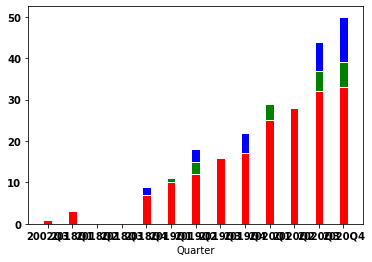

In [88]:
# Values of each group

bars1 = list(df_final['One Pager'].values)
bars2 = list(df_final['Invested'].values)
bars3 = list(df_final['Term Sheet'].values)

 
# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = list(np.arange(13))
 
# Names of group and bar width
names = list(df_final['Quarter'].astype(str))
barWidth = 0.35
 
# Create brown bars
plt.bar(r, bars1, color='red', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color='green', edgecolor='white', width=barWidth)
# Create green bars (top)
plt.bar(r, bars3, bottom=bars, color='blue', edgecolor='white', width=barWidth)
 
# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("Quarter")
 
# Show graphic
plt.show()
